# Tarefa: Classificar Homer e Bart com rede neural convolucional

Na tarefa anterior você desenvolveu uma rede neural densa para classificar os personagens utilizando a abordagem de extração de características. A ideia agora é usar as imagens do Homer e do Bart assim como fizemos nas aulas sobre a classificação dos gatos e cachorros, comparando as duas abordagens. Siga as seguintes instruções:

- Você pode fazer o download das imagens do Homer e do Bart, as quais já estão separadas nas respectivas pastas de treinamento e teste (75% para treinamento e 25% para teste)

- Como essa base de dados possui poucas imagens, utilize os recursos de Data Augmentation para gerar mais amostras

In [1]:
!pip install torch==1.4.0 torchvision==0.5.0

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 23.6MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


## Etapa 1: Importação das Bibliotecas

In [3]:
import torch
import zipfile

from torch import nn, optim
from torchvision import datasets, transforms

In [4]:
torch.manual_seed(123)

## Etapa 2: Construção do modelo

In [5]:
cls = nn.Sequential(
                    nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size = 2),
                    nn.Conv2d(32, 32, 3),
                    nn.ReLU(),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(in_features = 14*14*32, out_features = 4),
                    nn.ReLU(),
                    nn.Linear(4, 4),
                    nn.ReLU(),
                    nn.Linear(4, 1),
                    nn.Sigmoid()
)

In [6]:
criterion = nn.BCELoss()
optimizer = optim.Adam(cls.parameters())

## Etapa 3: Base de dados

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
path = '/content/gdrive/My Drive/dataset_personagens.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [9]:
path_train = '/content/dataset_personagens/training_set'
path_test = '/content/dataset_personagens/test_set'

In [10]:
transform_train = transforms.Compose([
                                      transforms.Resize([64, 64]),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(degrees = 7, 
                                                              translate = (0, 0.07),
                                                              shear = 0.2,
                                                              scale = (1, 1.2)
                                                              ),
                                      transforms.ToTensor()
                                      ])

In [11]:
transform_test = transforms.Compose([
                                     transforms.Resize([64, 64]),
                                     transforms.ToTensor()
                                     ])

In [13]:
train_dataset = datasets.ImageFolder(path_train, transform = transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 10, shuffle = True)

In [14]:
test_dataset = datasets.ImageFolder(path_test, transform = transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 10, shuffle = True)

## Etapa 4: Treinamento do modelo

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [16]:
cls.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=6272, out_features=4, bias=True)
  (8): ReLU()
  (9): Linear(in_features=4, out_features=4, bias=True)
  (10): ReLU()
  (11): Linear(in_features=4, out_features=1, bias=True)
  (12): Sigmoid()
)

In [17]:
def train_loop(loader, eopch):
    
  running_loss = 0.
  running_acc = 0.
  
  for i, data in enumerate(loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = cls(inputs)
    loss = criterion(outputs, labels.float().view(*outputs.shape))
    running_loss += loss.item()
    loss.backward()
    
    optimizer.step()

    predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
    equals = predicted == labels.view(*predicted.shape)
    acc = torch.mean(equals.float())
    running_acc += acc

    print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}' \
          .format(epoch + 1, i + 1, len(loader), loss, acc), end='\r')
    
  print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}' \
          .format(epoch + 1, running_loss/len(loader), running_acc/len(loader)))

In [19]:
for epoch in range(100):
    print('Treinando...')
    train_loop(train_loader, epoch)
    cls.eval()
    print('Validando...')
    train_loop(test_loader, epoch)
    cls.train()

Treinando...
ÉPOCA   1 FINALIZADA: perda 0.67125 - precisão 0.60667
Validando...
ÉPOCA   1 FINALIZADA: perda 0.66584 - precisão 0.62500
Treinando...
ÉPOCA   2 FINALIZADA: perda 0.64883 - precisão 0.65333
Validando...
ÉPOCA   2 FINALIZADA: perda 0.59435 - precisão 0.83750
Treinando...
ÉPOCA   3 FINALIZADA: perda 0.60572 - precisão 0.74833
Validando...
ÉPOCA   3 FINALIZADA: perda 0.69008 - precisão 0.68750
Treinando...
ÉPOCA   4 FINALIZADA: perda 0.64874 - precisão 0.64667
Validando...
ÉPOCA   4 FINALIZADA: perda 0.67084 - precisão 0.59583
Treinando...
ÉPOCA   5 FINALIZADA: perda 0.63839 - precisão 0.69500
Validando...
ÉPOCA   5 FINALIZADA: perda 0.54316 - precisão 0.82500
Treinando...
ÉPOCA   6 FINALIZADA: perda 0.59073 - precisão 0.76000
Validando...
ÉPOCA   6 FINALIZADA: perda 0.50733 - precisão 0.79583
Treinando...
ÉPOCA   7 FINALIZADA: perda 0.58401 - precisão 0.77500
Validando...
ÉPOCA   7 FINALIZADA: perda 0.45210 - precisão 0.88750
Treinando...
ÉPOCA   8 FINALIZADA: perda 0.57655

## Etapa 5: Avaliação do modelo

In [24]:
def classificar_imagem(fname):
  from PIL import Image
  import matplotlib.pyplot as plt
  imagem_teste = Image.open(path_test + '/' + fname)
  plt.imshow(imagem_teste)

  import numpy as np
  imagem_teste = imagem_teste.resize((64, 64))
  imagem_teste = np.array(imagem_teste.getdata()).reshape(*imagem_teste.size, 3)
  imagem_teste = imagem_teste / 255
  imagem_teste = imagem_teste.transpose(2, 0, 1)
  imagem_teste = torch.tensor(imagem_teste, dtype=torch.float).view(-1, *imagem_teste.shape)

  cls.eval()
  imagem_teste = imagem_teste.to(device)
  output = cls.forward(imagem_teste)
  if output > 0.5:
    output = 1
  else:
    output = 0
  print('Previsão: ', output)

  idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}

  return idx_to_class[output]

Previsão:  0


'bart'

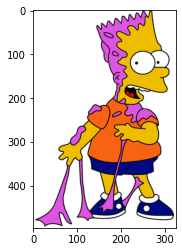

In [25]:
imagem = '/bart/bart1.bmp'
classificar_imagem(imagem)

Previsão:  1


'homer'

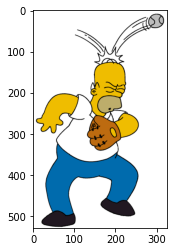

In [26]:
imagem = '/homer/homer7.bmp'
classificar_imagem(imagem)